In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mnist_preprocessing import *

%matplotlib inline

----MNIST dataset loaded----
Train data: 784 x 55000
Test data: 784 x 10000
(55000,)
(10000,)
----MNIST dataset loaded----
Train data: 784 x 55000
Test data: 784 x 10000
---- Affine Estimator MSE ----
Train data: 0.102928
Test data: 0.104586


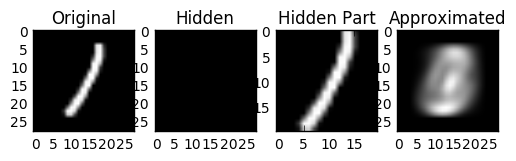

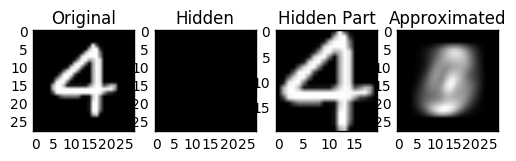

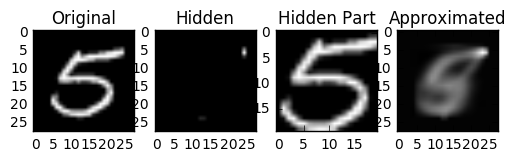

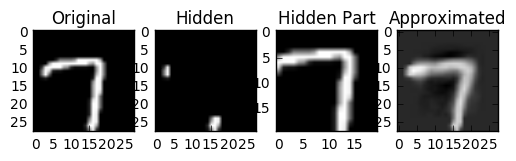

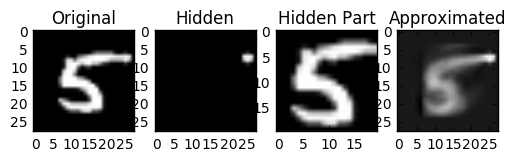

In [52]:
train, test = returnData()
train_labels, test_labels = returnLabels()

squareSideLength = 20
train_hideCenter, Xtrain_hideCenter, Ytrain_hideCenter, \
test_hideCenter, Xtest_hideCenter, Ytest_hideCenter = returnSquareData(squareSideLength)

u_x, u_y, cov_x, cov_yx = getStatistics(train, generateCenterSquareMask(squareSideLength))

def Wstar(cov_x, cov_yx):
    if cov_x.any():
        cov_x_inv = np.linalg.pinv(cov_x)
    else:
        cov_x_inv = cov_x
    W = np.dot(cov_yx, cov_x_inv)
    return W

def mmseEstimator(x, u_x, u_y, cov_x, cov_yx):
    W = Wstar(cov_x, cov_yx)
    dist = x - u_x.reshape((u_x.shape[0]), 1)
    return np.dot(W, dist) + u_y.reshape((u_y.shape[0]), 1)

Ytrain_hat = mmseEstimator(Xtrain_hideCenter, u_x, u_y, cov_x, cov_yx)
Ytest_hat = mmseEstimator(Xtest_hideCenter, u_x, u_y, cov_x, cov_yx)

maskVec = generateCenterSquareMask(squareSideLength)
x_idx = np.where([maskVec == 1])[1]
y_idx = np.where([maskVec == 0])[1]

approxImgVecs_train = np.zeros((train.shape[0], train.shape[1]))
approxImgVecs_test = np.zeros((test.shape[0], test.shape[1]))
approxImgVecs_train[x_idx, :] = Xtrain_hideCenter
approxImgVecs_train[y_idx, :] = Ytrain_hat
approxImgVecs_test[x_idx, :] = Xtest_hideCenter
approxImgVecs_test[y_idx, :] = Ytest_hat

for i in range(5):
    random = np.random.randint(0, 55000)    

    # original image
    original = train[:, random]
    originalImg = unpackcw(original, 28, 28)

    # hidden image
    hidden = train_hideCenter[:, random]
    hiddenImg = unpackcw(hidden, 28, 28)
    
    # hidden part
    hiddenPart = Ytrain_hideCenter[:, random]
    hiddenPartImg = unpackcw(hiddenPart, squareSideLength, squareSideLength)

    # approximated image
    approx = approxImgVecs_train[:, random]
    approxImg = unpackcw(approx, 28, 28)
    
    # plot
    plt.figure(i); 
    plt.subplot(1, 4, 1); plt.imshow(originalImg, cmap='gray'); plt.title('Original')
    plt.subplot(1, 4, 2); plt.imshow(hiddenImg, cmap='gray'); plt.title('Hidden')
    plt.subplot(1, 4, 3); plt.imshow(hiddenPartImg, cmap='gray'); plt.title('Hidden Part')
    plt.subplot(1, 4, 4); plt.imshow(approxImg, cmap='gray'); plt.title('Approximated')
    
# calculate the mse of the training and test sets using affine estimator
# this is only on the regenerated center
diff_train = Ytrain_hat - Ytrain_hideCenter
trainMSEs = np.zeros(55000)
for i in range(55000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = Ytest_hat - Ytest_hideCenter
testMSEs = np.zeros(10000)
for i in range(10000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Affine Estimator MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

In [53]:
# ----------------------------
#    Blanked to Unknown
# ----------------------------
predicted_train_pre = np.load('predictedTrain_square_20.npy')
predicted_test_pre = np.load('predictedTest_square_20.npy')

predicted_train = np.copy(train)
predicted_train[y_idx] = predicted_train_pre[y_idx]
predicted_test = np.copy(test)
predicted_test[y_idx] = predicted_test_pre[y_idx]

# predicted_train_autoencoder = np.copy(predicted_train)
# predicted_test_autoencoder = np.copy(predicted_test)

#-------------------------
#  MSE for unknown
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train[y_idx]
temp2 = test[y_idx]
temp3 = predicted_train[y_idx]
temp4 = predicted_test[y_idx]

diff_train = temp1 - temp3
trainMSEs = np.zeros(55000)
for i in range(55000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - temp4
testMSEs = np.zeros(10000)
for i in range(10000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

# np.save('autoencoder_mnist_train_square_14.npy', predicted_train)
# np.save('autoencoder_mnist_test_square_14.npy', predicted_test)

---- Generated Data MSE ----
Train data: 0.092021
Test data: 0.093244


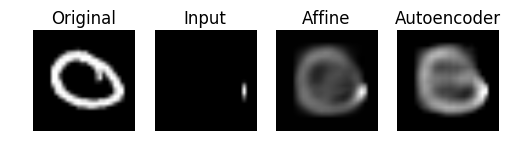

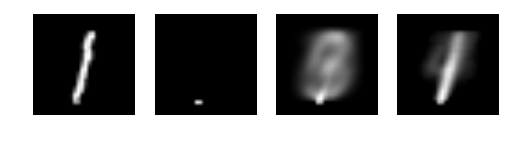

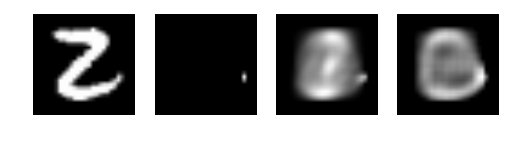

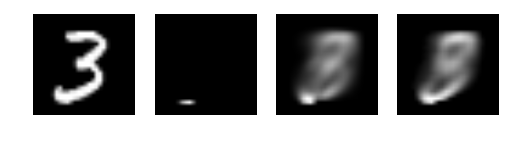

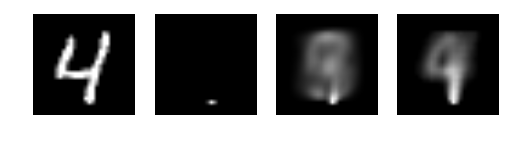

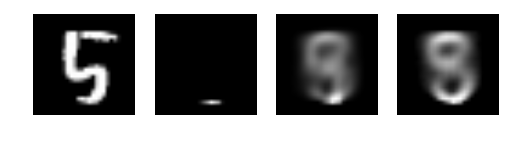

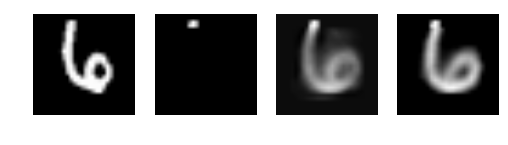

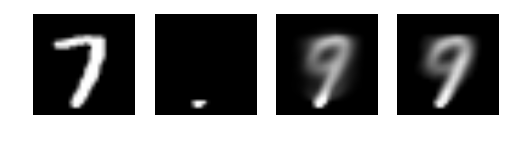

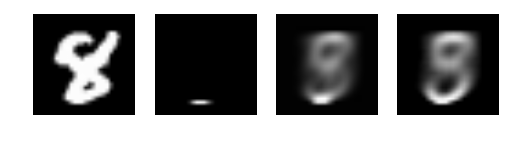

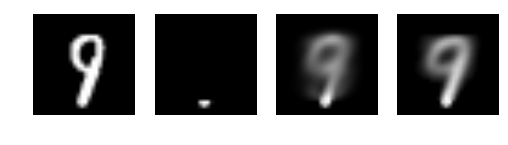

In [58]:
for i in range(10):  
    idxs = np.where(test_labels==i)[0]
    idx = np.random.randint(0, len(idxs))
    randomTest = idxs[idx]
    
    origTest = test[:, randomTest]
    hiddenTest = test_hideCenter[:, randomTest]
    mmseTest = approxImgVecs_test[:, randomTest]
    nn_test = predicted_test[:, randomTest]

    imgOrigTest = unpackcw(origTest, 28, 28)
    imgHiddenTest = unpackcw(hiddenTest, 28, 28)
    imgApproxTest = unpackcw(mmseTest, 28, 28)
    imgNNTest = unpackcw(nn_test, 28, 28)
    
    plt.figure(i);
    if (i==0):
        plt.subplot(1, 4, 1); plt.imshow(imgOrigTest, cmap='gray'); plt.title('Original'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(imgHiddenTest, cmap='gray'); plt.title('Input'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(imgApproxTest, cmap='gray'); plt.title('Affine'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(imgNNTest, cmap='gray'); plt.title('Autoencoder'); plt.axis('off')
    else:
        plt.subplot(1, 4, 1); plt.imshow(imgOrigTest, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(imgHiddenTest, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(imgApproxTest, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(imgNNTest, cmap='gray'); plt.axis('off')
    plt.savefig('test_mnist_squares_20_%d.png' %i)

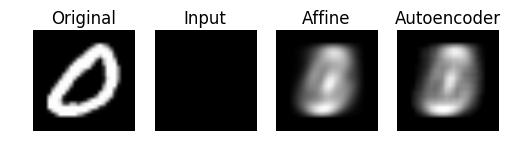

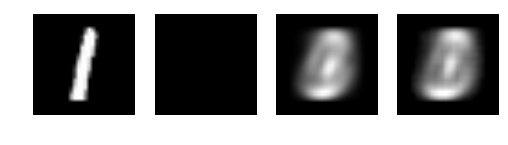

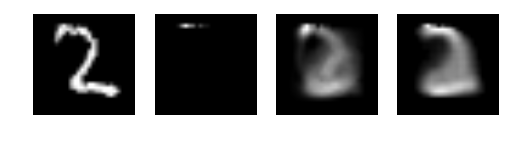

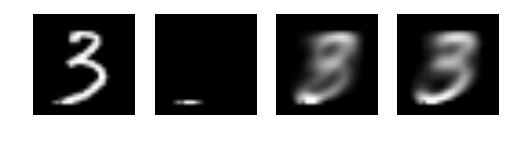

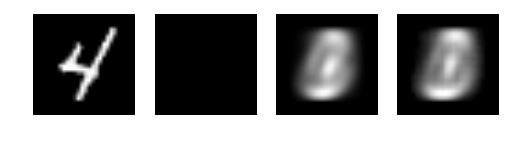

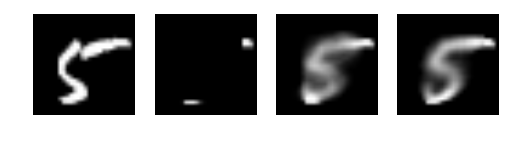

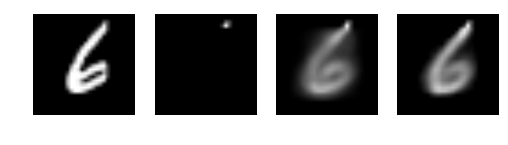

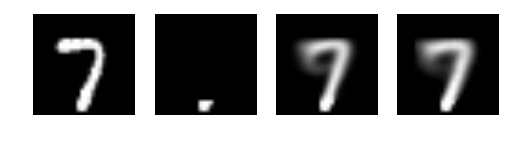

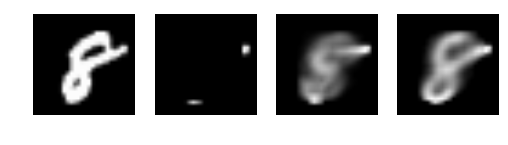

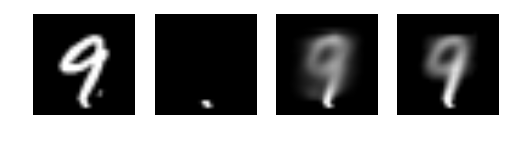

In [59]:
for i in range(10):  
    idxs = np.where(train_labels==i)[0]
    idx = np.random.randint(0, len(idxs))
    randomTrain = idxs[idx]

    origTrain = train[:, randomTrain]
    hiddenTrain = train_hideCenter[:, randomTrain]
    mmseTrain = np.clip(approxImgVecs_train[:, randomTrain], 0, 1)
    nn_train = np.clip(predicted_train[:, randomTrain], 0, 1)
    
    imgOrigTrain = unpackcw(origTrain, 28, 28)
    imgHiddenTrain = unpackcw(hiddenTrain, 28, 28)
    imgApproxTrain = unpackcw(mmseTrain, 28, 28)
    imgNNTrain = unpackcw(nn_train, 28, 28)

    imgsToGrid[i*gridDimX] = imgOrigTrain
    imgsToGrid[i*gridDimX + 1] = imgHiddenTrain
    imgsToGrid[i*gridDimX + 2] = imgApproxTrain
    imgsToGrid[i*gridDimX + 3] = imgNNTrain

    plt.figure(i);
    if (i==0):
        plt.subplot(1, 4, 1); plt.imshow(imgOrigTrain, cmap='gray'); plt.title('Original'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(imgHiddenTrain, cmap='gray'); plt.title('Input'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(imgApproxTrain, cmap='gray'); plt.title('Affine'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(imgNNTrain, cmap='gray'); plt.title('Autoencoder'); plt.axis('off')
    else:
        plt.subplot(1, 4, 1); plt.imshow(imgOrigTrain, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(imgHiddenTrain, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(imgApproxTrain, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(imgNNTrain, cmap='gray'); plt.axis('off')
    plt.savefig('train_mnist_squares_20_%d.png' %i)

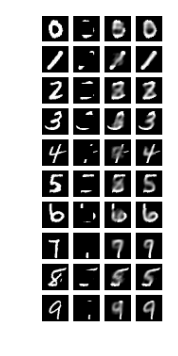

In [12]:
plt.figure()
plt.imshow(imgGridTest, cmap='gray')
plt.axis('off');
plt.savefig('ae_sampleCompletions_%d_2.png' %squareSideLength, dpi=2000)

In [6]:
# ----------------------------
#    Blanked to Original
# ----------------------------
predicted_train_pre = np.load('predictedTrain_square_14.npy')
predicted_test_pre = np.load('predictedTest_square_14.npy')

predicted_train = np.copy(predicted_train_pre)
predicted_train[x_idx] = Xtrain_hideCenter
predicted_test = np.copy(predicted_test_pre)
predicted_test[x_idx] = Xtest_hideCenter

#-------------------------
#  MSE for whole image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train
temp2 = test

diff_train = temp1 - predicted_train_pre
trainMSEs = np.zeros(55000)
for i in range(55000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test_pre
testMSEs = np.zeros(10000)
for i in range(10000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

#-------------------------
#  MSE for right half image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train[y_idx]
temp2 = test[y_idx]
temp3 = predicted_train[y_idx]
temp4 = predicted_test[y_idx]

diff_train = temp1 - temp3
trainMSEs = np.zeros(55000)
for i in range(55000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - temp4
testMSEs = np.zeros(10000)
for i in range(10000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE


IOError: [Errno 2] No such file or directory: 'predictedTrain_square_14.npy'

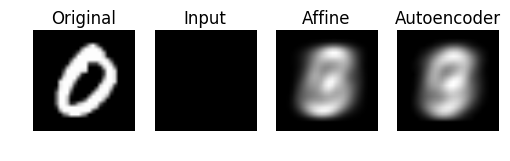

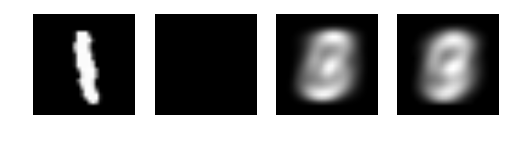

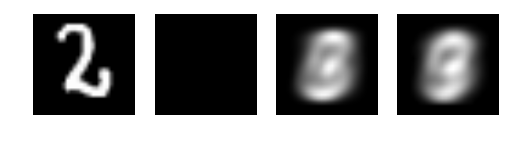

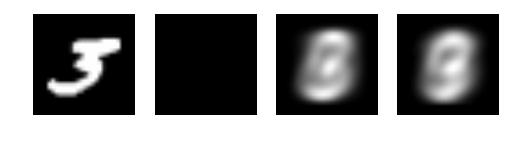

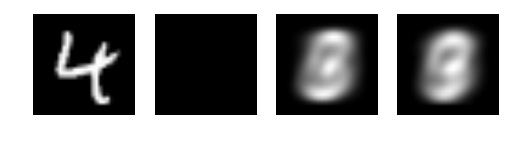

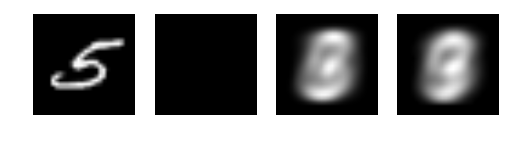

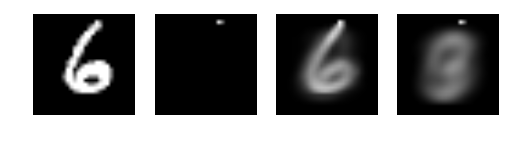

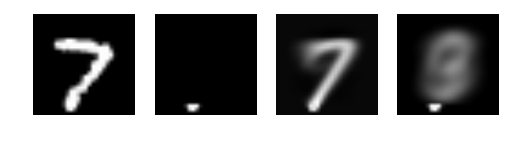

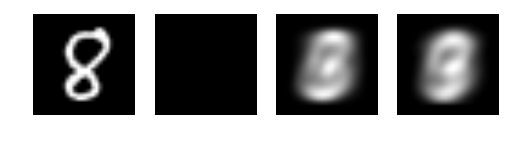

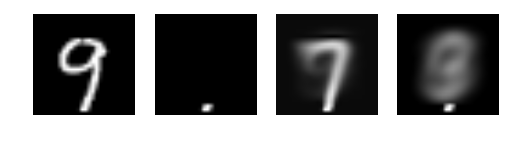

In [18]:
for i in range(10):  
    idxs = np.where(train_labels==i)[0]
    idx = np.random.randint(0, len(idxs))
    randomTrain = idxs[idx]

    origTrain = train[:, randomTrain]
    hiddenTrain = train_hideCenter[:, randomTrain]
    mmseTrain = approxImgVecs_train[:, randomTrain]
    nn_train = predicted_train[:, randomTrain]
    nn_train_generated = predicted_train_pre[:, randomTrain]
    
    imgOrigTrain = unpackcw(origTrain, 28, 28)
    imgHiddenTrain = unpackcw(hiddenTrain, 28, 28)
    imgApproxTrain = unpackcw(mmseTrain, 28, 28)
    imgNNTrain = unpackcw(nn_train, 28, 28)
    imgNNTrain_generated = unpackcw(nn_train_generated, 28, 28)
    
    plt.figure(i);
    if (i==0):
        plt.subplot(1, 4, 1); plt.imshow(imgOrigTrain, cmap='gray'); plt.title('Original'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(imgHiddenTrain, cmap='gray'); plt.title('Input'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(imgApproxTrain, cmap='gray'); plt.title('Affine'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(imgNNTrain, cmap='gray'); plt.title('Autoencoder'); plt.axis('off')
        #plt.subplot(1, 5, 5); plt.imshow(imgNNTrain_generated, cmap='gray'); plt.title('NN Gen'); plt.axis('off')
        plt.savefig('Figs_train_square_22x22_%d' %i)
    else:
        plt.subplot(1, 4, 1); plt.imshow(imgOrigTrain, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(imgHiddenTrain, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(imgApproxTrain, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(imgNNTrain, cmap='gray'); plt.axis('off')
        #plt.subplot(1, 5, 5); plt.imshow(imgNNTrain_generated, cmap='gray'); plt.title('NN Gen'); plt.axis('off')
        plt.savefig('Figs_train_square_22x22_%d' %i)


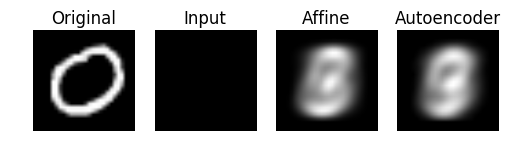

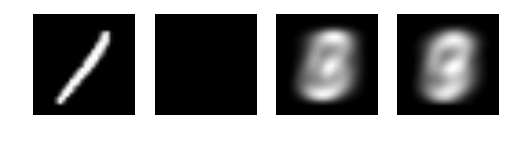

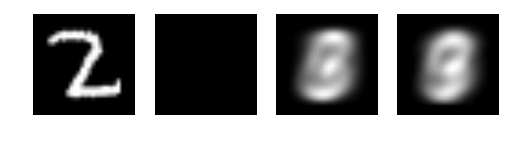

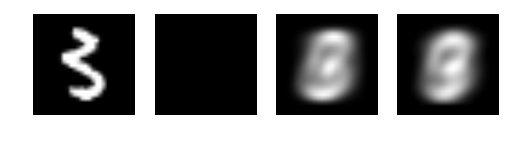

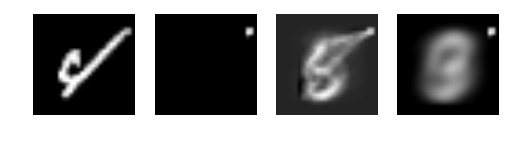

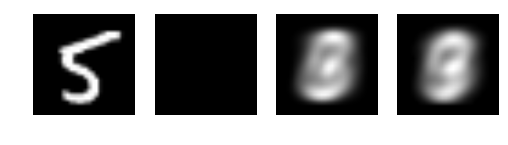

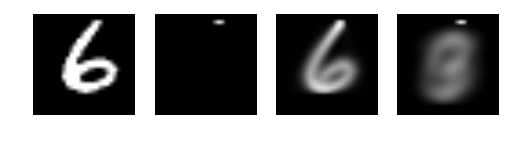

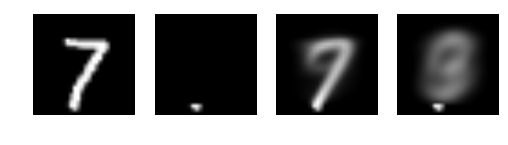

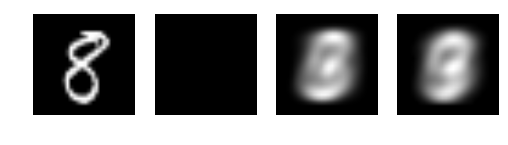

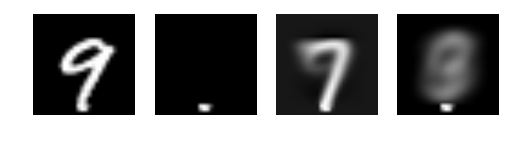

In [19]:
for i in range(10):  
    idxs = np.where(test_labels==i)[0]
    idx = np.random.randint(0, len(idxs))
    randomTest = idxs[idx]
    
    origTest = test[:, randomTest]
    hiddenTest = test_hideCenter[:, randomTest]
    mmseTest = approxImgVecs_test[:, randomTest]
    nn_test = predicted_test[:, randomTest]
    nn_test_generated = predicted_test_pre[:, randomTest]

    imgOrigTest = unpackcw(origTest, 28, 28)
    imgHiddenTest = unpackcw(hiddenTest, 28, 28)
    imgApproxTest = unpackcw(mmseTest, 28, 28)
    imgNNTest = unpackcw(nn_test, 28, 28)
    imgNNTest_gen = unpackcw(nn_test_generated, 28, 28)
    
    plt.figure(i);
    if (i==0):
        plt.subplot(1, 4, 1); plt.imshow(imgOrigTest, cmap='gray'); plt.title('Original'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(imgHiddenTest, cmap='gray'); plt.title('Input'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(imgApproxTest, cmap='gray'); plt.title('Affine'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(imgNNTest, cmap='gray'); plt.title('Autoencoder'); plt.axis('off')
        #plt.subplot(1, 5, 5); plt.imshow(imgNNTest_gen, cmap='gray'); plt.title('NN Gen'); plt.axis('off')
        plt.savefig('Figs_test_square_22x22_%d' %i)
    else:
        plt.subplot(1, 4, 1); plt.imshow(imgOrigTest, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(imgHiddenTest, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(imgApproxTest, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(imgNNTest, cmap='gray'); plt.axis('off')
        #plt.subplot(1, 5, 5); plt.imshow(imgNNTest_gen, cmap='gray'); plt.title('NN Gen'); plt.axis('off')
        plt.savefig('Figs_test_square_22x22_%d' %i)

In [3]:
# ----------------------------
#    Other testing - Various MSE metrics (just generated or whole image lolz)
# ----------------------------
predicted_train = np.load('predictedTrain.npy')
predicted_test = np.load('predictedTest.npy')

#-------------------------
#  MSE for whole image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train
temp2 = test

diff_train = temp1 - predicted_train
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

#------------------------------------------
#  MSE for unknown portion of image
#------------------------------------------
maskVec = generateCenterSquareMask(8)
x_idx = np.where([maskVec == 1])[1]
y_idx = np.where([maskVec == 0])[1]

hidden_predictedTrain, X_predictedTrain, Y_predictedTrain = hideData(predicted_train, maskVec)
hidden_predictedTest, X_predictedTest, Y_predictedTest = hideData(predicted_test, maskVec)

temp1 = train[y_idx]
temp2 = test[y_idx]

diff_train = temp1 - Y_predictedTrain
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - Y_predictedTest
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE (Middle Image - Y) ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

temp1 = train[x_idx]
temp2 = test[x_idx]

diff_train = temp1 - X_predictedTrain
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - X_predictedTest
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)
testMSE2 = np.mean(np.multiply(diff_test, diff_test))
print '---- Generated Data MSE (Outside Image - X) ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE
print '---- Either way of defining MSE works ----'
print testMSE
print testMSE2

---- Generated Data MSE ----
Train data: 0.014384
Test data: 0.015986
---- Generated Data MSE (Middle Image - Y) ----
Train data: 0.057725
Test data: 0.065758
---- Generated Data MSE (Outside Image - X) ----
Train data: 0.010531
Test data: 0.011562
---- Either way of defining MSE works ----
0.0115618266905
0.0115618266905


In [4]:
testSplit_X = np.zeros((10, Xtest_hideCenter.shape[0], Xtest_hideCenter.shape[1]/10))
testSplit_Y = np.zeros((10, Ytest_hideCenter.shape[0], Ytest_hideCenter.shape[1]/10))

testSplit_X_hat = np.zeros((10, X_predictedTest.shape[0], X_predictedTest.shape[1]/10))
testSplit_Y_hat = np.zeros((10, Y_predictedTest.shape[0], Y_predictedTest.shape[1]/10))

for i in range(10):
  for j in range(10):
    testSplit_X[i, :, j*10:(j+1)*10] = Xtest_hideCenter[:, j*100+i*10:j*100+(i+1)*10]
    testSplit_Y[i, :, j*10:(j+1)*10] = Ytest_hideCenter[:, j*100+i*10:j*100+(i+1)*10]
    testSplit_X_hat[i, :, j*10:(j+1)*10] = X_predictedTest[:, j*100+i*10:j*100+(i+1)*10]
    testSplit_Y_hat[i, :, j*10:(j+1)*10] = Y_predictedTest[:, j*100+i*10:j*100+(i+1)*10]

In [5]:
temp = np.zeros(10)
for i in range(10):
    diff_Split = testSplit_Y_hat[i] - testSplit_Y[i]
    temp[i] = np.mean(np.multiply(diff_Split, diff_Split))
    
print temp
print np.mean(temp)
print np.std(temp)

[ 0.06386917  0.0671013   0.06814566  0.06640649  0.0661793   0.0638123
  0.06692971  0.06482716  0.06233799  0.06797259]
0.0657581665416
0.00185194491088


(784, 55000)


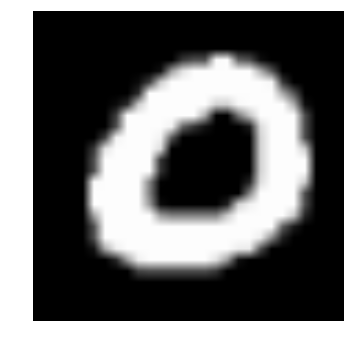

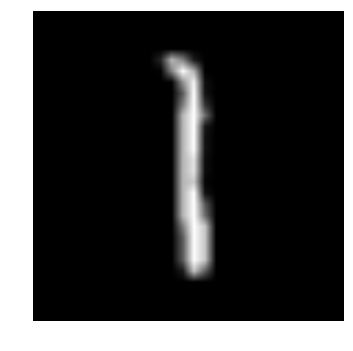

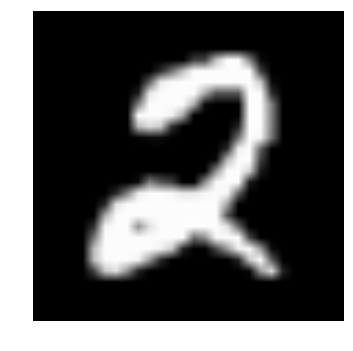

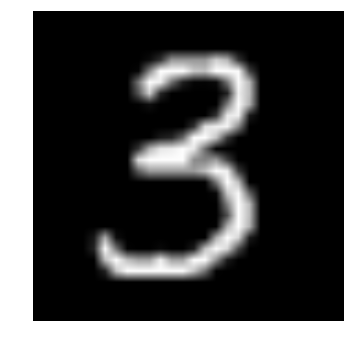

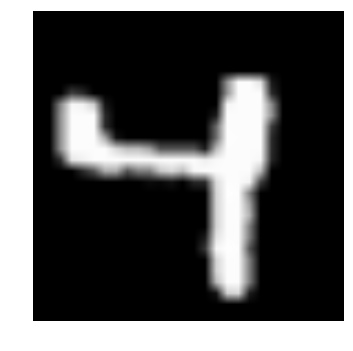

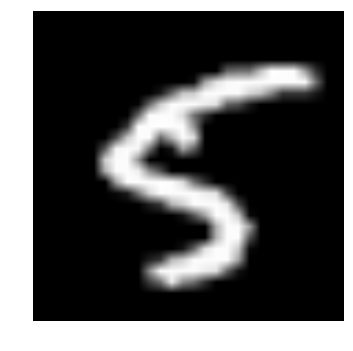

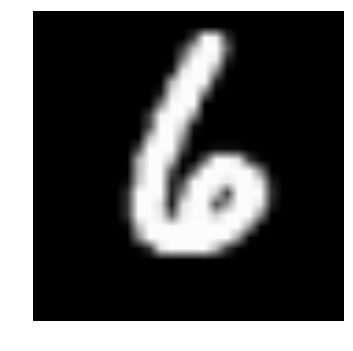

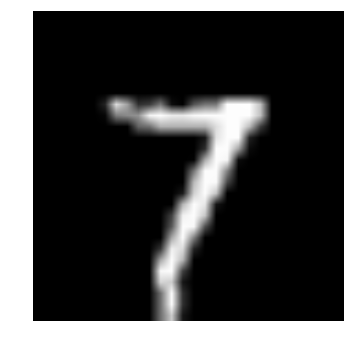

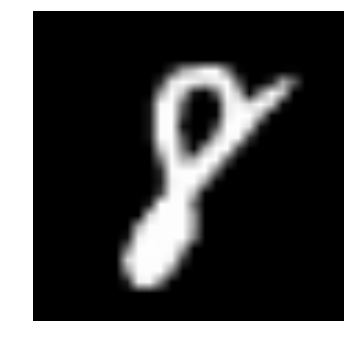

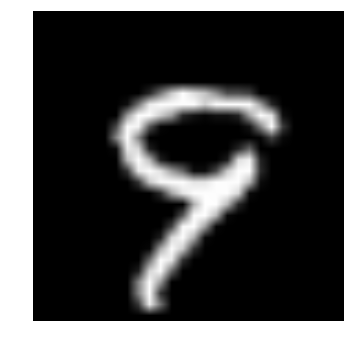

In [5]:
print train.shape
for i in range(10):
    idxs = np.where(train_labels==i)[0]
    idx = np.random.randint(0, len(idxs))
    randomTrain = idxs[idx]

    origTrain = train[:, randomTrain]
    imgOrigTrain = unpackcw(origTrain, 28, 28)
    plt.figure(i)
    plt.imshow(imgOrigTrain, cmap='gray')
    plt.axis('off')
    plt.savefig("example %d" %i)

In [ ]:
for i in range(10):  
    origTrain = train[:, randomTrain]
    hiddenTrain = train_hideCenter[:, randomTrain]
    mmseTrain = approxImgVecs_train[:, randomTrain]
    nn_train = predicted_train[:, randomTrain]
    nn_train_generated = predicted_train_pre[:, randomTrain]
    
    imgOrigTrain = unpackcw(origTrain, 28, 28)
    imgHiddenTrain = unpackcw(hiddenTrain, 28, 28)
    imgApproxTrain = unpackcw(mmseTrain, 28, 28)
    imgNNTrain = unpackcw(nn_train, 28, 28)
    imgNNTrain_generated = unpackcw(nn_train_generated, 28, 28)
    
    plt.figure(i);
    if (i==0):
        plt.subplot(1, 4, 1); plt.imshow(imgOrigTrain, cmap='gray'); plt.title('Original'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(imgHiddenTrain, cmap='gray'); plt.title('Input'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(imgApproxTrain, cmap='gray'); plt.title('Affine'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(imgNNTrain, cmap='gray'); plt.title('Autoencoder'); plt.axis('off')
        #plt.subplot(1, 5, 5); plt.imshow(imgNNTrain_generated, cmap='gray'); plt.title('NN Gen'); plt.axis('off')
        plt.savefig('Figs_train_square_22x22_%d' %i)
    else:
        plt.subplot(1, 4, 1); plt.imshow(imgOrigTrain, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(imgHiddenTrain, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(imgApproxTrain, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(imgNNTrain, cmap='gray'); plt.axis('off')
        #plt.subplot(1, 5, 5); plt.imshow(imgNNTrain_generated, cmap='gray'); plt.title('NN Gen'); plt.axis('off')
        plt.savefig('Figs_train_square_22x22_%d' %i)
